In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from glob import glob

In [34]:
def check_replicate_passed(scenario, replicate, var_num="2", experiment="exp4"):
    summary = pd.read_csv(base / experiment / scenario.split("/")[-1] / replicate.split("/")[-1] / "outputSummary.csv.gz")
    if summary[[f"var{var_num}Isymp[current]", f"var{var_num}Iasymp[current]"]].iloc[-1].sum() < 1:
        return False
    else:
#         print(summary[[f"var{var_num}Isymp[current]", f"var{var_num}Iasymp[current]"]].iloc[-1].sum())
#         summary[[f"var{var_num}Isymp[current]", f"var{var_num}Iasymp[current]"]].plot()
        return True

def scenario_to_title(scenario):
    scenario = scenario.split("/")[-1]
    scenario = scenario.replace("tau_", "Variant 1: ")
    scenario = scenario.replace("_var2_1.4_seed2p", "")
    scenario = scenario.replace("_5", ", Location: 5")
    scenario = scenario.replace("_seed2t_", ", Emergence Day: ")
#     scenario = scenario.replace("", "")
    return scenario

def plot_scenario_variant_scatter(scenario, ax, cutoff = None):
    replicates = [i.split("/")[-1] for i in sorted([i for i in glob(str(base / experiment / scenario / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))]
    var1 = []
    var2 = []
    for replicate in replicates:
        summary = pd.read_csv(base / experiment / scenario.split("/")[-1] / replicate.split("/")[-1] / "outputSummary.csv.gz")
        if cutoff is None:
            cutoff = summary.tick.max()
        summary = summary[summary.tick <= cutoff]
        if experiment == "exp4":
            v1 = summary[["var1Isymp[in]", "var1Iasymp[in]", 'var1var2Isymp[in]', 'var1var2Iasymp[in]']].sum().sum()
            v2 = summary[["var2Isymp[in]", "var2Iasymp[in]", 'var2var1Isymp[in]', 'var2var1Iasymp[in]']].sum().sum()     
        else:
            v1 = summary[["var1Isymp[in]", "var1Iasymp[in]"]].sum().sum()
            v2 = summary[["var2Isymp[in]", "var2Iasymp[in]"]].sum().sum()        
    
        var1.append(v1)
        var2.append(v2)
            
    reg = linregress(var1, var2)
    
def plot_with_bounds(v1, ax, name="v1"):
    v1.median(axis=1).plot(ax=ax, color=colors[name], linewidth = 3, label=names[name])
    v1.quantile(0.05, axis=1).plot(ax=ax, color=colors[name], linestyle="--", label="_none_")
    v1.quantile(0.95, axis=1).plot(ax=ax, color=colors[name], linestyle="--", label="_none_")

In [93]:
base = Path("/scratch/jho5ze/bionets/epihiper/data/output/")

experiment = "exp4"
tau="0.02"

colors = {"v1":"tab:orange", "v2":"tab:red", "prev":"tab:blue"}
names = {"v1":"Variant 1", "v2":"Variant 2", "prev":"Prevalence"}

In [94]:
scenarios = [i.split("/")[-1] for i in sorted(glob(str(base / experiment / "*")))]
scenarios = sorted([s for s in scenarios if tau in s], key = lambda row: int(row.split("_")[-1]))
scenarios = sorted(scenarios, key = lambda row: row.split("_")[-3])
   
scenarios

['tau_0.02_var2_1.4_seed2p_51_seed2t_90',
 'tau_0.02_var2_1.4_seed2p_51_seed2t_120',
 'tau_0.02_var2_1.4_seed2p_51_seed2t_150',
 'tau_0.02_var2_1.4_seed2p_51059_seed2t_90',
 'tau_0.02_var2_1.4_seed2p_51059_seed2t_120',
 'tau_0.02_var2_1.4_seed2p_51059_seed2t_150',
 'tau_0.02_var2_1.4_seed2p_51121_seed2t_90',
 'tau_0.02_var2_1.4_seed2p_51121_seed2t_120',
 'tau_0.02_var2_1.4_seed2p_51121_seed2t_150']

In [95]:
scenario = scenarios[0]
replicates = [i.split("/")[-1] for i in sorted([i for i in glob(str(base / experiment / scenario / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))]


In [96]:
def plot_v1_v2_prev(scenario, ax):
    v1s = []
    v2s = []
    replicates = [i.split("/")[-1] for i in sorted([i for i in glob(str(base / experiment / scenario / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))]

    for replicate in replicates:
        summary = pd.read_csv(base / experiment / scenario.split("/")[-1] / replicate.split("/")[-1] / "outputSummary.csv.gz")
    #     if cutoff is None:
    #         cutoff = summary.tick.max()
    #     summary = summary[summary.tick <= cutoff]
        if experiment == "exp4":
            v1 = summary[["var1Isymp[in]", "var1Iasymp[in]", 'var1var2Isymp[in]', 'var1var2Iasymp[in]']].sum(axis=1)
            v2 = summary[["var2Isymp[in]", "var2Iasymp[in]", 'var2var1Isymp[in]', 'var2var1Iasymp[in]']].sum(axis=1)  
        else:
            v1 = summary[["var1Isymp[in]", "var1Iasymp[in]"]].sum(axis=1)
            v2 = summary[["var2Isymp[in]", "var2Iasymp[in]"]].sum(axis=1)

        v1s.append(v1)
        v2s.append(v2)

    twinx = ax.twinx()
    v1 = pd.concat(v1s, axis=1)
    v2 = pd.concat(v2s, axis=1)
    prev = v2 / (v1 + v2)
    plot_with_bounds(v1, ax, name="v1")
    plot_with_bounds(v2, ax, name="v2")
    plot_with_bounds(prev, twinx, name="prev")
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = twinx.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper left")
    ax.set_ylabel("Incidence of Infection", fontsize=12)
    twinx.set_ylabel("Variant 2 Prevalence", fontsize=12)
    ax.set_title(scenario_to_title(scenario), fontsize=14)

In [15]:

#     break
# v2.plot()

Text(0.5, 1.0, 'Variant 1: 0.03, Location: 51, Emergence Day: 90')

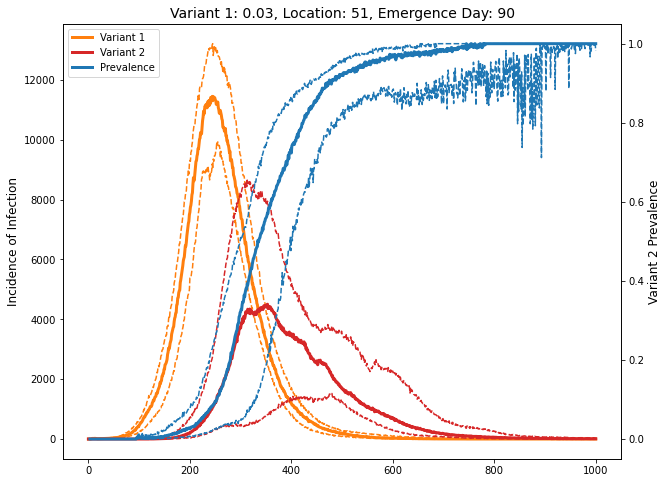

In [44]:
fig, ax = plt.subplots(figsize=(10,8))
twinx = ax.twinx()
v1 = pd.concat(v1s, axis=1)
v2 = pd.concat(v2s, axis=1)
prev = v2 / (v1 + v2)
plot_with_bounds(v1, ax, name="v1")
plot_with_bounds(v2, ax, name="v2")
plot_with_bounds(prev, twinx, name="prev")
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = twinx.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc="upper left")
ax.set_ylabel("Incidence of Infection", fontsize=12)
twinx.set_ylabel("Variant 2 Prevalence", fontsize=12)
ax.set_title(scenario_to_title(scenario), fontsize=14)

In [45]:
len(scenarios)

9

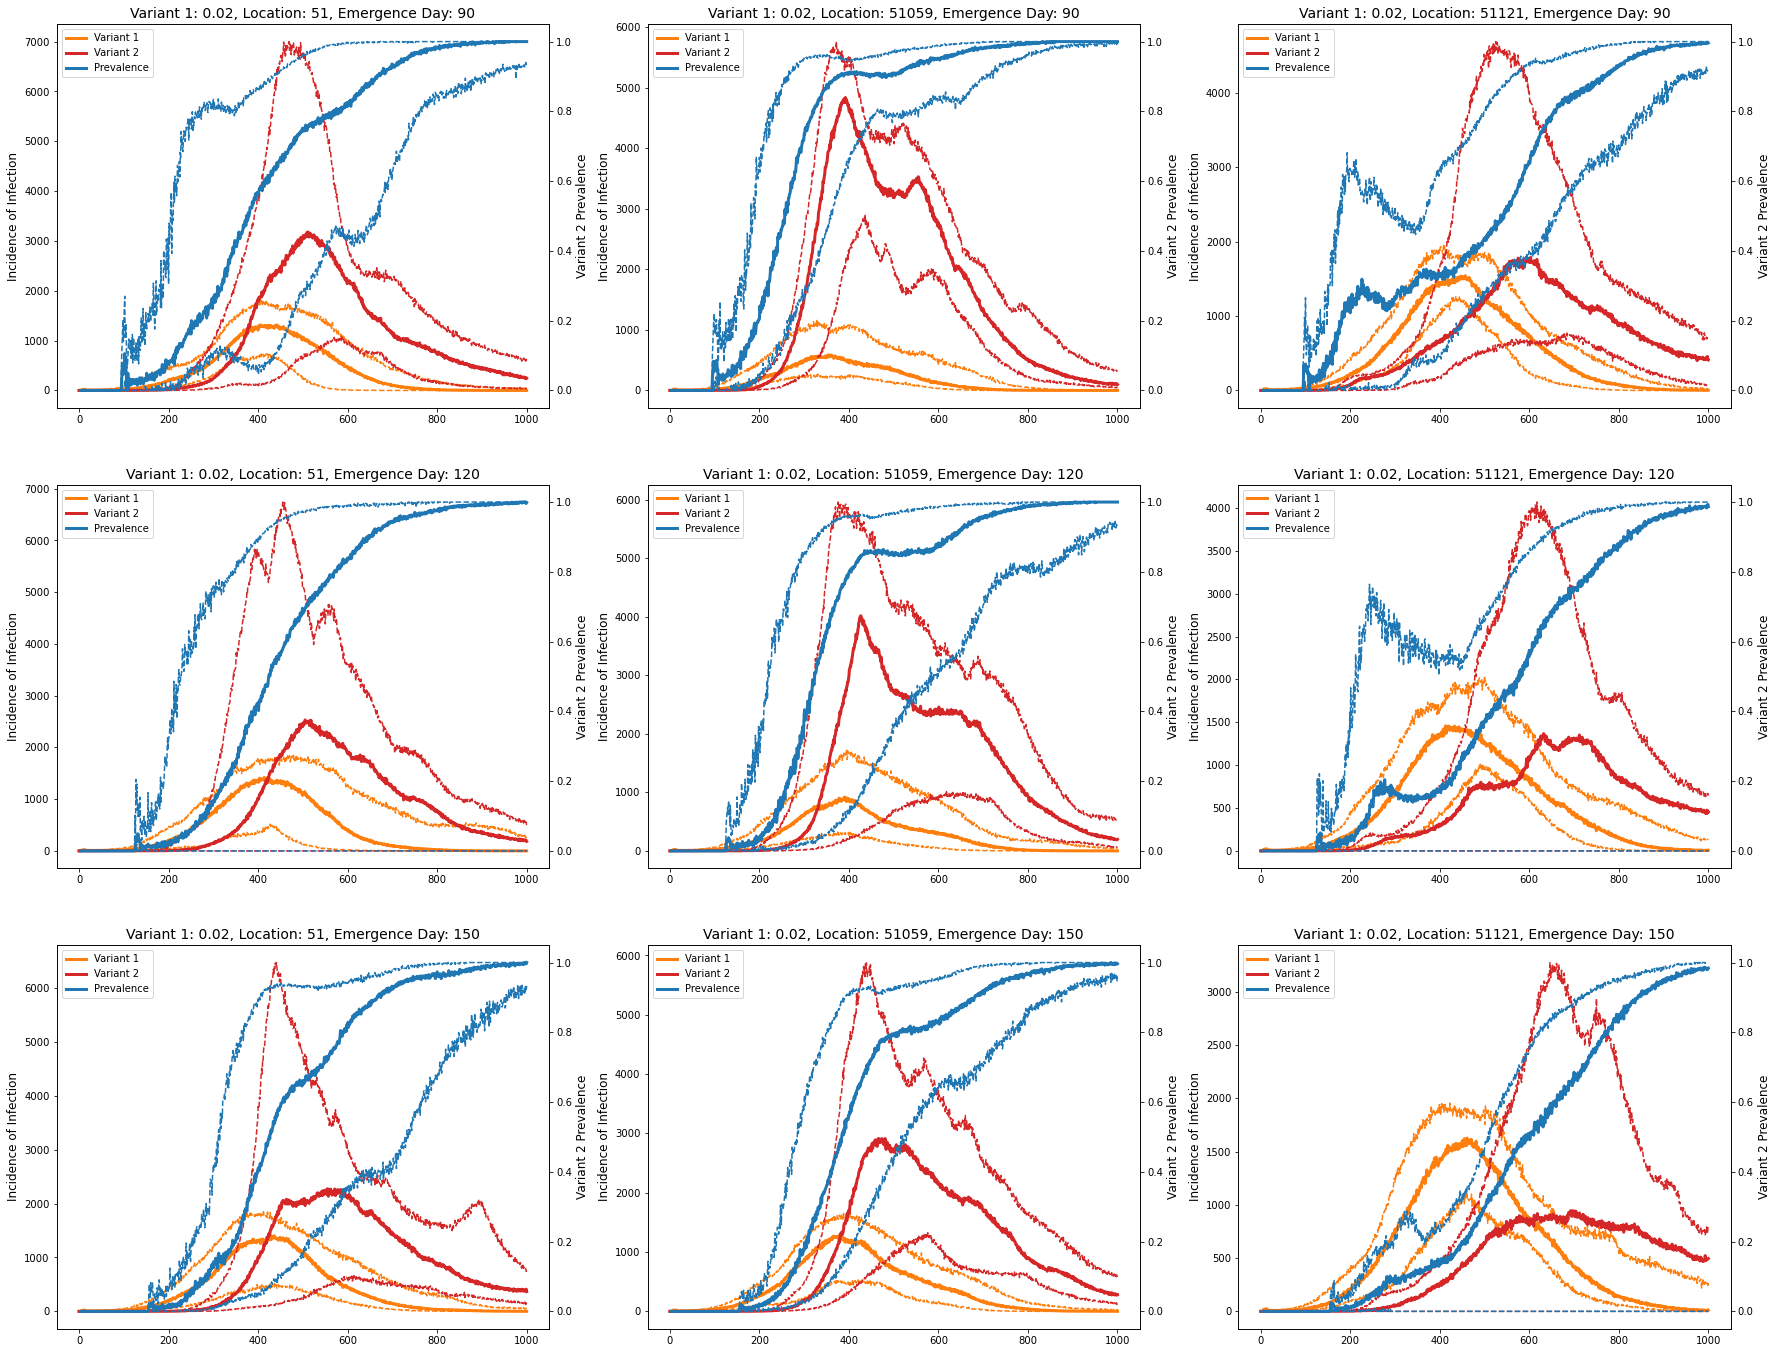

In [97]:
fig, axs = plt.subplots(figsize=(30,24), ncols=3, nrows=3)
for ix, scenario in enumerate(scenarios):
    ax = axs[ix %3, ix // 3]
    plot_v1_v2_prev(scenario, ax)
plt.savefig("v1_v2_prev_exp4_tau_0.02.png", dpi=100, facecolor="white", bbox_inches="tight")

In [83]:
variants = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date"], dtype={"state":str})
variants.variant = variants.variant.apply(lambda row: row if (row[:2] != "AY") else "B.1.617.2")

In [72]:
cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-states.csv", parse_dates=["date"], dtype={"fips":str})
cases = cases.pivot(index="date", columns="fips", values="cases").diff().rolling(7).mean()

In [84]:
us_variants = variants.groupby(["date", "variant"]).count().reset_index()
us_variants = us_variants.pivot(index="date", columns="variant", values="submission_date").fillna(0)
us_variants = (us_variants.T / us_variants.sum(axis=1)).T

variants = variants.groupby(["date", "state", "variant"]).count().reset_index()


In [85]:
va_variants = variants[variants.state == "51"]
va_variants = va_variants.pivot(index="date", columns="variant", values="submission_date").fillna(0)
va_variants = (va_variants.T / va_variants.sum(axis=1)).T

In [91]:
variants[variants.state == "51"].pivot(index="date", columns="variant", values="submission_date").fillna(0)["B.1.1.529"].sum()

2.0

In [ ]:
variants[variants.state == "51"].pivot(index="date", columns="variant", values="submission_date").fillna(0)["B.1.1.529"].sum()

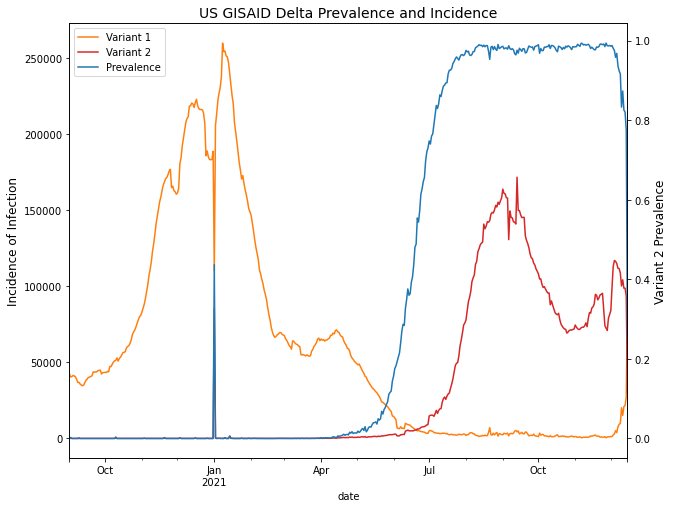

In [88]:
variant = "B.1.617.2"
date_cutoff = "2020-09-01"
rel_cases = cases.sum(axis=1).loc[date_cutoff:]
prev = us_variants[variant].loc[date_cutoff:]
v1 = (1-prev) * rel_cases
v2 = prev * rel_cases

fig, ax = plt.subplots(figsize=(10,8))
twinx = ax.twinx()

v1.plot(ax=ax, label="Variant 1", color="tab:orange")
v2.plot(ax=ax, label="Variant 2", color="tab:red")
prev.plot(ax=twinx, label="Prevalence", color="tab:blue")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = twinx.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc="upper left")
ax.set_ylabel("Incidence of Infection", fontsize=12)
twinx.set_ylabel("Variant 2 Prevalence", fontsize=12)
ax.set_title("US GISAID Delta Prevalence and Incidence", fontsize=14)
plt.savefig("US_GISAID_delta_prevalence_and_incidence.png", facecolor="white", dpi=100, bbox_inches="tight")

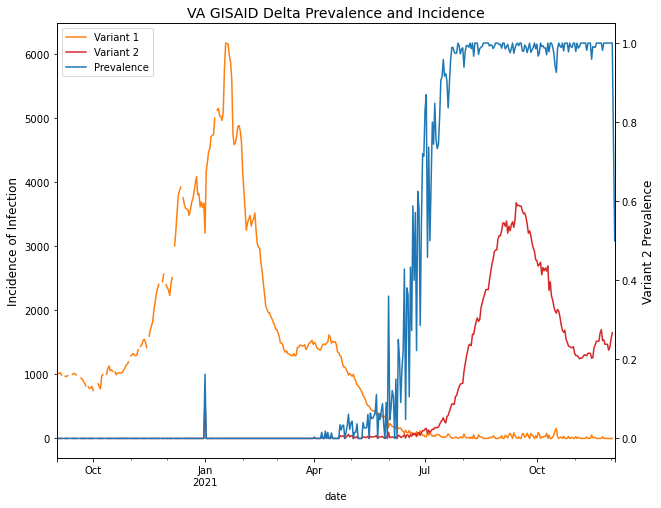

In [92]:
variant = "B.1.617.2"
date_cutoff = "2020-09-01"
rel_cases = cases["51"].loc[date_cutoff:]
prev = va_variants[variant].loc[date_cutoff:]
v1 = (1-prev) * rel_cases
v2 = prev * rel_cases

fig, ax = plt.subplots(figsize=(10,8))
twinx = ax.twinx()

v1.plot(ax=ax, label="Variant 1", color="tab:orange")
v2.plot(ax=ax, label="Variant 2", color="tab:red")
prev.plot(ax=twinx, label="Prevalence", color="tab:blue")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = twinx.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc="upper left")
ax.set_ylabel("Incidence of Infection", fontsize=12)
twinx.set_ylabel("Variant 2 Prevalence", fontsize=12)
ax.set_title("VA GISAID Delta Prevalence and Incidence", fontsize=14)
plt.savefig("VA_GISAID_delta_prevalence_and_incidence.png", facecolor="white", dpi=100, bbox_inches="tight")